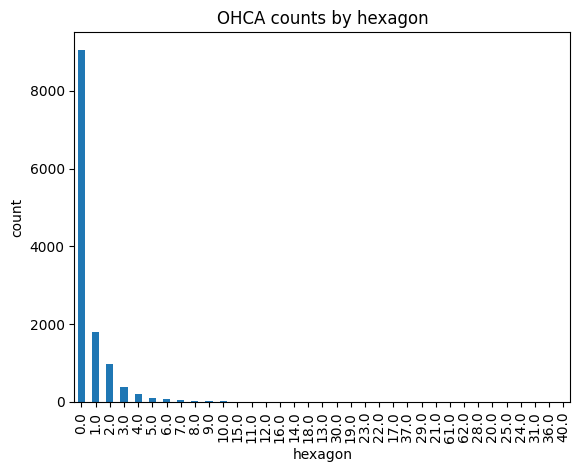

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# read main_hexagon_df.csv
df = pd.read_csv('main_hexagon_df.csv')
# check if predictions are in the dataframe
if 'predictions' in df.columns:
    # drop predictions column
    df.drop('predictions', axis=1, inplace=True)
#rename unnamed column
df.rename(columns={'Unnamed: 0':'hex_id'}, inplace=True)
# make it a index
df.set_index('hex_id', inplace=True)

# apply np.maximum(0, df['OHCA']) to OHCA column
df['OHCA'] = np.maximum(0, df['OHCA'])

# make a bar chart of OHCA counts by hexagon
df['OHCA'].value_counts().plot(kind='bar')
plt.title('OHCA counts by hexagon')
plt.xlabel('hexagon')
plt.ylabel('count')
plt.show()

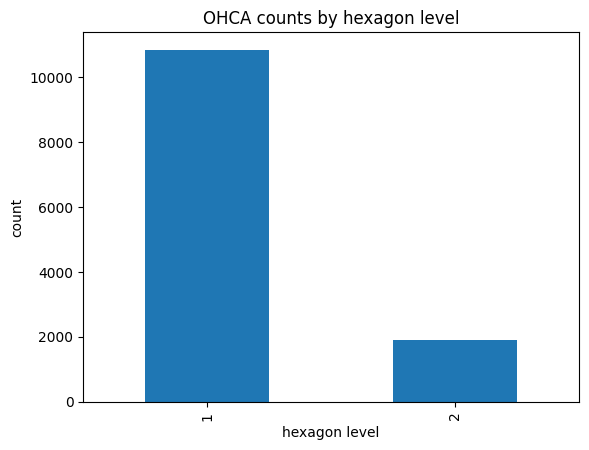

In [2]:
# group ohca values by [0, 1], [2, 3], [4, 5], [6, 7], [8, 9]
df['lvl2'] = 1
# take top 10% of the hexagons and assign lvl2 to 1
threshold = df['OHCA'].quantile(0.9)
df.loc[df['OHCA'] >= threshold, 'lvl2'] = 2
# sort by number in the front
df['lvl2'].value_counts().sort_index().plot(kind='bar')
plt.title('OHCA counts by hexagon level')
plt.xlabel('hexagon level')
plt.ylabel('count')
plt.show()

hex_id
892aac96187ffff    1
892a9301b03ffff    2
892aac94b6fffff    1
892af620c93ffff    1
892af63722fffff    1
                  ..
892a122cb53ffff    1
892a1358023ffff    1
892a1359ba7ffff    2
892af052047ffff    1
892af63613bffff    1
Name: lvl2, Length: 12755, dtype: int64




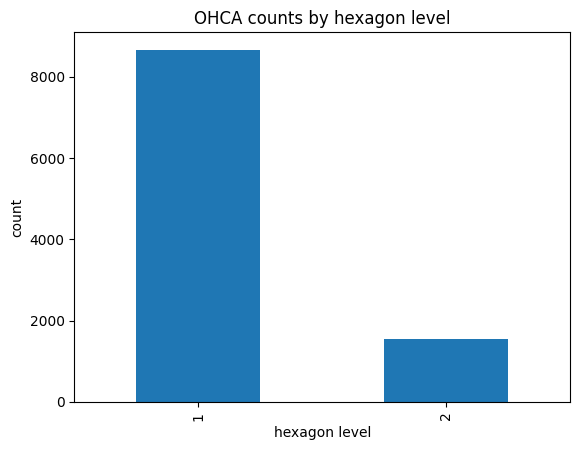

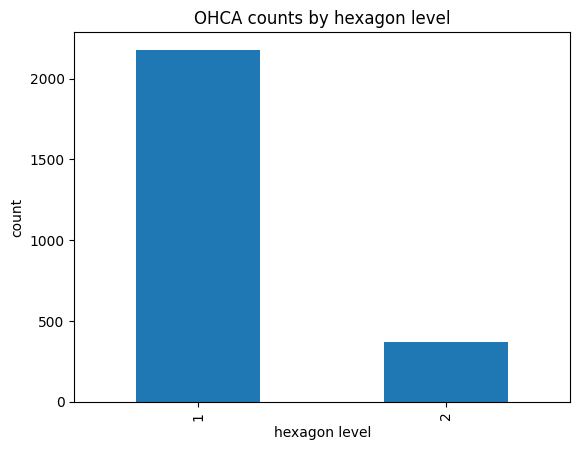

XGBRegressor
RMSE: 0.3336983328183164
MSE: 0.11135457732572387
MAE: 0.2131794674496518
R2: 0.10800527975408758
[1.3962104, 1.3552953, 0.98813295, 1.1104492, 1.0620791, 1.6533663, 1.2386171, 0.9671702, 1.0390061, 1.0435493, 1.0514374, 1.0699399, 1.0897887, 1.3962104, 1.3962104, 1.04867, 1.0340654, 1.011847, 1.3962104, 1.0905037, 0.99471307, 1.3962104, 1.16791, 1.1315035, 1.0451157, 1.0591598, 1.1274271, 1.3962104, 1.0568322, 1.1408205, 1.0511136, 1.0241799, 1.142153, 1.0156906, 1.1614778, 1.0502801, 1.5598476, 1.3962104, 1.1799381, 1.3962104, 1.0581852, 0.91864204, 1.3852414, 1.1646836, 1.6586659, 1.0282125, 1.4060296, 1.054841, 1.1812354, 1.0293932, 1.024976, 1.1020592, 1.1597319, 1.1703326, 1.6121053, 1.0333716, 1.3962104, 1.2035908, 1.0068017, 1.0645293, 0.9939814, 1.3537331, 1.4477255, 1.007919, 1.1406593, 1.0718695, 1.0250437, 0.999276, 1.0591598, 1.3962104, 1.0036663, 1.1119164, 1.032238, 1.3962104, 1.1229467, 1.0356364, 1.1202174, 1.0136495, 1.0193092, 1.0390382, 0.89365417, 1.01

In [3]:
# train a bunch of regression models
from sklearn.linear_model import LinearRegression
# knn
from sklearn.neighbors import KNeighborsRegressor
# decision tree
from sklearn.tree import DecisionTreeRegressor
# random forest
from sklearn.ensemble import RandomForestRegressor
# xgboost
from xgboost import XGBRegressor

# split data into train and test
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# shuffle data
df = df.sample(frac=1)

# split data into train and test
X = df.drop(['OHCA', 'lvl2'], axis=1)
y = df['lvl2']
print(f"{y}\n\n")

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# show a bar with ohca counts for test and train data with lvl2 column, same as above
fig, ax = plt.subplots()
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('OHCA counts by hexagon level')
plt.xlabel('hexagon level')
plt.ylabel('count')
plt.show()
y_test.value_counts().sort_index().plot(kind='bar')
plt.title('OHCA counts by hexagon level')
plt.xlabel('hexagon level')
plt.ylabel('count')
plt.show()

# train a bunch of regression models
models = [XGBRegressor(), RandomForestRegressor()]

# train and evaluate
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__)
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    print('R2: {}'.format(r2_score(y_test, y_pred)))
    # apply a np.maximum(0, y_pred) to y_pred
    y_pred = np.maximum(0, y_pred)
    print(list(y_pred))
    print('\n\n')

In [4]:
# make a map out of predictions and test data
import folium
import h3
m = folium.Map(location=[0,0], zoom_start=11)

# max value of fill
y_max = y_test.max()

test_df = pd.DataFrame({'hex_id': X_test.index, 'lvl2': y_test})
pred_df = pd.DataFrame({'hex_id': X_test.index, 'lvl2': y_pred})

# add hexagons to map
for index, row in test_df.iterrows():
    hex_id = row['hex_id']
    lvl2 = row['lvl2']
    fill = lvl2/y_max
    bdry = h3.cell_to_boundary(hex_id)
    folium.Polygon(locations=bdry, fill_color='red', fill_opacity=fill).add_to(m)
m

In [5]:
# now try classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# shuffle data
df = df.sample(frac=1)

# split data into train and test
X = df.drop(['OHCA', 'lvl2'], axis=1)
y = df['lvl2'] - 1

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = [XGBClassifier(), RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier()]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__)
    print('Accuracy: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print('Precision: {}'.format(mean_squared_error(y_test, y_pred)))
    print('Recall: {}'.format(mean_absolute_error(y_test, y_pred)))
    print('F1: {}'.format(r2_score(y_test, y_pred)))
    print('\n\n')

# make a map out of predictions and test data
import folium
import h3
m = folium.Map(location=[0,0], zoom_start=11)

# max value of fill
y_max = y_test.max()

test_df = pd.DataFrame({'hex_id': X_test.index, 'lvl2': y_test})
pred_df = pd.DataFrame({'hex_id': X_test.index, 'lvl2': y_pred})

# add hexagons to map
for index, row in test_df.iterrows():
    hex_id = row['hex_id']
    lvl2 = row['lvl2']
    fill = lvl2/y_max
    bdry = h3.cell_to_boundary(hex_id)
    folium.Polygon(locations=bdry, fill_color='red', fill_opacity=fill).add_to(m)

XGBClassifier
Accuracy: 0.3894935347880747
Precision: 0.15170521364170914
Recall: 0.15170521364170914
F1: -0.16164935789273027



RandomForestClassifier
Accuracy: 0.3899964317500023
Precision: 0.15209721677773422
Recall: 0.15209721677773422
F1: -0.16465103582010165



KNeighborsClassifier
Accuracy: 0.42464272344117776
Precision: 0.18032144257154056
Recall: 0.18032144257154056
F1: -0.38077184659084207



DecisionTreeClassifier
Accuracy: 0.45018398608232457
Precision: 0.2026656213249706
Recall: 0.2026656213249706
F1: -0.5518674884510117



